# Hands on : introduction to BDT on HEP dataset

## Standard Imports

In [1]:
#COLAB=False #if running on local anaconda installation https://docs.anaconda.com/anaconda/install/
COLAB=True #if running on https://colab.research.google.com/notebooks/welcome.ipynb

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from IPython import display
from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
np.random.seed(31415) # set the random seed for the reproducibility

In [3]:
# Fix environment if necessary
if COLAB:
    !pip install eli5 # permutation importance package, now obsolete but good enough
    pass
else:    
    # install xgboost and lighgbm, two popular Boosted Decision Tree packages
    # normally it is just a matter of a few pip install but there might be some glitches
    # note : I have better experience with pip install than conda install. 
    # the following need to be done only once. To be commented out later
    #!pip install xgboost # might need to run !pip install cmake first   
    #!pip install lightgbm # might need to run before brew install libopm on a mac
    #!pip install eli5
    pass

import xgboost
print (xgboost.__version__) # Tested with 1.0.2, version above 1 is recommended. Colab has 0.9.0, good enough 
import lightgbm
print (lightgbm.__version__) # Tested with 2.3.1
import eli5
print (eli5.__version__) # Tested with 0.10.1



     |████████████████████████████████| 112kB 5.3MB/s 
0.90
2.2.3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


0.10.1


In [6]:
if COLAB:
    #### Reading files from Google Drive
    # one need a google account to be identified
    # select a google account, then cut and paste the long password in the pop up field
    !pip install PyDrive
    import os
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

# Load events

In [7]:
if COLAB:

    #attach dataset from google drive 
    download = drive.CreateFile({'id': '1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4'})
    download.GetContentFile("dataWW_d1_600k.csv.gz")


    datapath=""


    !ls -lrt
else :
    # make sure the file is available locally. 
    #Should be downloaded from https://drive.google.com/open?id=1nlXp7P-xq_jip4aPE0j0mnPhYnIOcBv4
    !ls -lrt # what is in the local directory
    datapath="/Users/rousseau/Google\ Drive/GD_openData/dataWW_ATLAS_openData13TeV_filtered/"

    !ls -lrt {datapath} # what is in the data directory
    datapath=os.path.abspath(datapath).replace("\ ", " ")  # try to normalise the path (annoyance with the space)
    print ("Will take data from : ",datapath)

filename=os.path.join(datapath,"dataWW_d1_600k.csv.gz")
#load data
# data was created from ATLAS Open Data see doc
# http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html
dfall = pd.read_csv(filename) 

#shuffle the events, already done but just to be safe
dfall = dfall.sample(frac=1).reset_index(drop=True)
print ("File loaded with ",dfall.shape[0], " events ")



total 35076
drwxr-xr-x 1 root root     4096 Dec  2 22:04 sample_data
-rw-r--r-- 1 root root      720 Dec  7 19:29 adc.json
-rw-r--r-- 1 root root 35905611 Dec  7 19:29 dataWW_d1_600k.csv.gz
File loaded with  600000  events 


At this point, it should tell you "File Loaded with XXX events". If not, it could not access the datafile, no point going further !

# Examine dataset

In [8]:
#dump list of feature
dfall.columns

Index(['eventNumber', 'label', 'met_et', 'met_phi', 'lep_n', 'lep_pt_0',
       'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1',
       'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1', 'lep_type_0',
       'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1', 'jet_eta_0', 'jet_eta_1',
       'jet_phi_0', 'jet_phi_1', 'jet_E_0', 'jet_E_1', 'mcWeight', 'runNumber',
       'channelNumber'],
      dtype='object')

In [9]:
#examine first few events
dfall.head()

,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,402756,1,25.609,0.42452,2,48.295,15.214,0.73991,2.27420,-2.316400,-1.39410,62129.0,74721.0,-1,1,13,11,2,26.32,20.064,-1.1350,-2.07540,-2.8092,2.0740,45397.0,81304.0,0.000002,284500,345323
1,101274,0,196.560,1.31140,2,69.459,21.081,-0.52666,0.22380,0.023132,-0.67855,79317.0,21611.0,-1,1,13,13,2,192.12,36.217,-1.2643,-0.69746,-2.2147,-1.9152,367670.0,45733.0,0.000288,284500,363492
2,468437,1,45.653,-2.76860,2,45.927,22.822,-1.61910,-2.00770,1.901700,-0.11248,120480.0,86498.0,-1,1,11,11,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000029,284500,345324
3,272337,1,49.415,-0.57805,2,45.929,14.263,1.55280,0.12809,2.254700,-2.54810,113360.0,14380.0,-1,1,13,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000029,284500,345324
4,354546,1,71.988,-2.60390,2,62.029,21.453,-0.51082,-0.38177,0.236200,1.40820,70300.0,23036.0,-1,1,11,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000002,284500,345323


In [10]:
#examine feature distribution
dfall.describe()

,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
count,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.0,600000.000000
mean,7.029775e+05,0.666667,60.365356,-0.008556,2.005748,60.270328,28.133970,0.000269,-0.000664,0.005219,0.008524,1.164008e+05,5.630948e+04,-0.027027,0.027037,11.907273,11.958010,1.334185,59.606114,13.521164,-1.934521,-4.402337,-1.939645,-4.401941,1.375410e+05,4.125468e+04,0.000218,284500.0,351379.666667
std,4.568961e+05,0.471405,48.153210,1.812778,0.076061,42.676858,20.352272,1.210614,1.235890,1.811177,1.814205,1.083341e+05,5.748834e+04,0.999636,0.999635,0.995692,0.999119,1.232632,79.586143,38.074439,3.349404,3.491304,3.489197,3.559421,1.980717e+05,8.990068e+04,0.000736,0.0,8564.720183
min,1.000000e+00,0.000000,0.044211,-3.141600,2.000000,25.000000,7.000300,-2.700000,-2.699900,-3.141600,-3.141600,2.501300e+04,7.003800e+03,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,-0.045557,284500.0,345323.000000
25%,3.498568e+05,0.000000,33.196000,-1.577600,2.000000,36.624750,15.316000,-0.899650,-0.946043,-1.560200,-1.562900,5.221675e+04,2.329100e+04,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,0.000002,284500.0,345323.000000
50%,6.678815e+05,1.000000,50.082000,-0.018694,2.000000,48.229500,23.644000,0.003413,0.002974,0.014583,0.018823,8.184450e+04,3.824900e+04,-1.000000,1.000000,11.000000,11.000000,1.000000,38.744000,-7.000000,-0.891010,-7.000000,-1.210600,-7.000000,7.501700e+04,-7.000000e+00,0.000029,284500.0,345324.000000
75%,1.001273e+06,1.000000,73.032250,1.559300,2.000000,68.979000,34.149000,0.901950,0.942210,1.573000,1.577300,1.412400e+05,6.730825e+04,1.000000,1.000000,13.000000,13.000000,2.000000,84.291250,26.881000,0.724705,-0.821005,0.967753,-1.088575,1.766200e+05,5.060500e+04,0.000197,284500.0,363492.000000
max,1.997995e+06,1.000000,7062.200000,3.141600,5.000000,7041.400000,744.900000,2.699800,2.700000,3.141500,3.141600,7.041600e+06,2.107900e+06,1.000000,1.000000,13.000000,13.000000,13.000000,1658.200000,1429.800000,2.500000,2.500000,3.141600,3.141600,5.638800e+06,2.784300e+06,0.052420,284500.0,363492.000000


In [12]:
label_weights = (dfall[dfall.label==0].mcWeight.sum(), dfall[dfall.label==1].mcWeight.sum() ) 
print("total label weights",label_weights)


label_nevents = (dfall[dfall.label==0].shape[0], dfall[dfall.label==1].shape[0] )
print ("total class number of events",label_nevents)









total label weights (124.6622944642, 6.2000533976)
total class number of events (200000, 400000)


## Event selection

In [13]:
print (dfall.shape)
fulldata=dfall[dfall.lep_n==2] # only keep events with exactly two leptons 
print (fulldata.shape)



(600000, 29)
(596571, 29)


In [14]:
#hide label and weights in separate vectors
#they are not real features

#WARNING : there should be no selection nor shuffling later on !
target = fulldata["label"]
del fulldata["label"]

#hide weight in separate vector
weights = fulldata["mcWeight"]
del fulldata["mcWeight"]
fulldata.shape

(596571, 27)


# DO NOT MODIFY ANYTHING ABOVE
... and always rerun from this cell whenever you change something below

In [15]:
# for simplicity of the exercise only keep some features
# this is actually making a copy from fulldata
data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1'])
#data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#       'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1']
print (data.shape)
data.head()




(596571, 6)


,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.609,0.42452,48.295,15.214,-2.316400,-1.39410
1,196.560,1.31140,69.459,21.081,0.023132,-0.67855
2,45.653,-2.76860,45.927,22.822,1.901700,-0.11248
3,49.415,-0.57805,45.929,14.263,2.254700,-2.54810
4,71.988,-2.60390,62.029,21.453,0.236200,1.40820


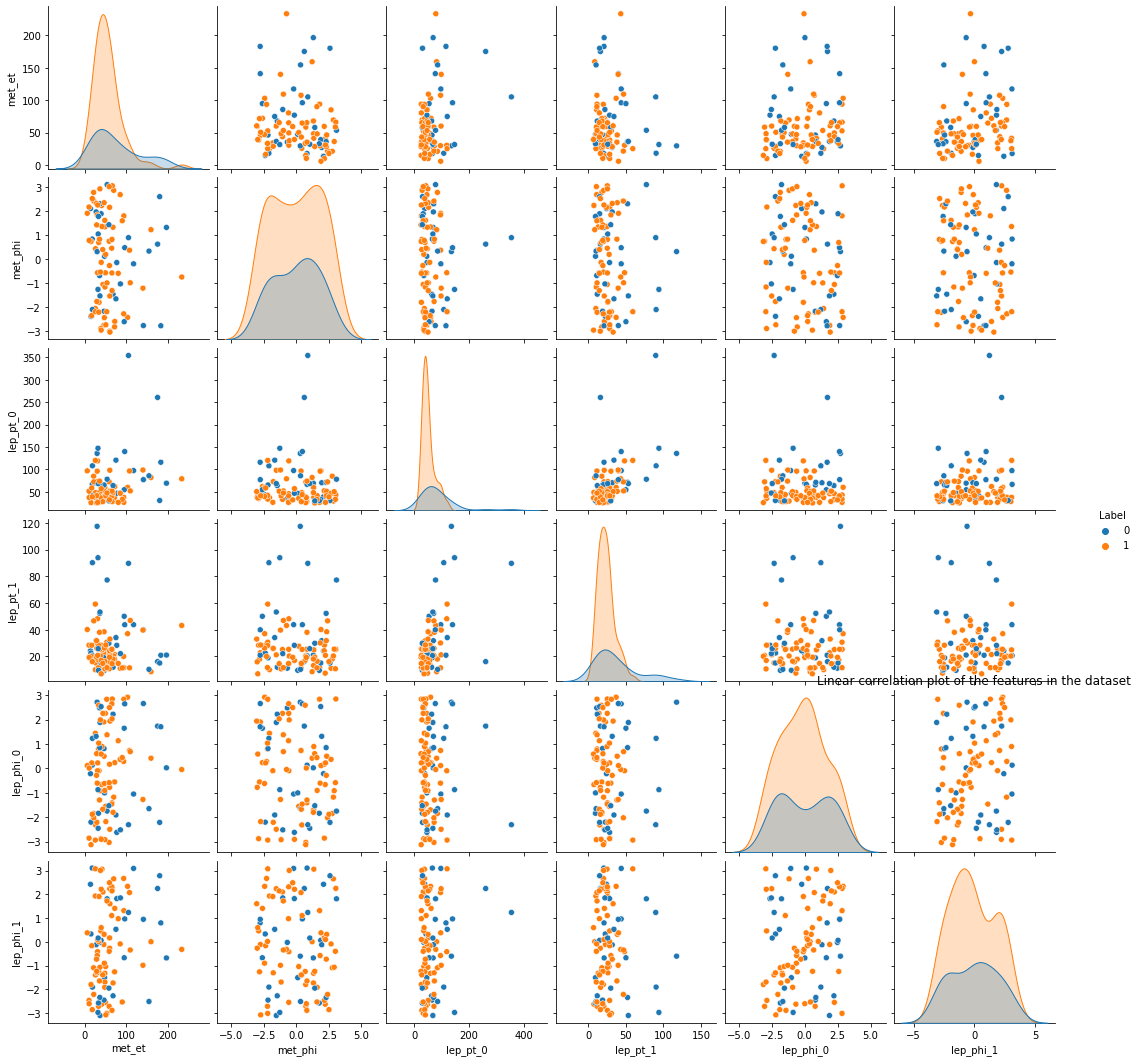

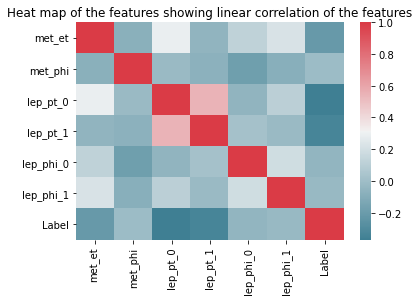

array([0, 1])

In [16]:
import seaborn as sns

ExploreData = data[:100].copy()
ExploreData['Label'] = target[:100].copy()

sns.pairplot(ExploreData, hue = 'Label')
plt.title('Linear correlation plot of the features in the dataset')
plt.show()
sns.heatmap(ExploreData.corr(), xticklabels=ExploreData.columns, yticklabels=ExploreData.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot = False)
plt.title('Heat map of the features showing linear correlation of the features')
plt.show()

np.unique(ExploreData.Label)

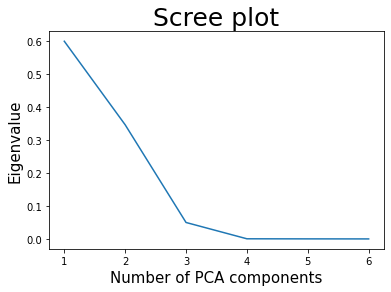

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ExploreData.dropna(axis=0,inplace=True)

pca = PCA()
components = pca.fit_transform(ExploreData[data.columns])
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.title('Scree plot', fontsize = 25)
plt.xlabel('Number of PCA components', fontsize = 15)
plt.ylabel('Eigenvalue', fontsize = 15)
plt.show()

In [18]:
import plotly.express as px
from sklearn.decomposition import PCA

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}


fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=ExploreData.Label
)
fig.update_traces(diagonal_visible=False)
fig.show()

## Examine the weights

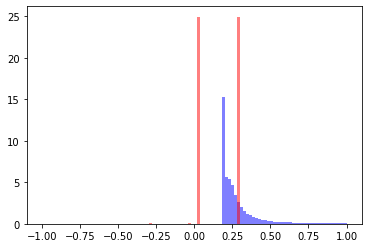

In [19]:
plt.figure()
bins=np.linspace(-1,1,101)
plt.hist(weights[target==0]*1000,bins=bins,color='b',alpha=0.5,density=True)
plt.hist(weights[target==1]*10000,bins=bins,color='r',alpha=0.5,density=True)
plt.show()

In [20]:
label_n_weights=np.zeros(2)
label_sum_weights=np.zeros(2)
label_mean_weights=np.zeros(2)
label_std_weights=np.zeros(2)
label_neff_fraction=np.zeros(2)

for i in range(2):
  label_n_weights[i]=weights[target==i].size
  label_mean_weights[i]=weights[target==i].mean()
  label_std_weights[i]=weights[target==i].std()
  label_sum_weights[i]=weights[target==i].sum()
  label_neff_fraction[i]=1/(1+(label_std_weights[i]/label_mean_weights[i])**2)

print ("Weights quantities for background (target==0) and signal (target==1)")
print ("Weights sum",label_sum_weights)
print ("N events",label_n_weights)
print ("Weights mean",label_mean_weights)
print ("Weights std",label_std_weights)
print ("Weights Neff fraction",label_neff_fraction)

Weights quantities for background (target==0) and signal (target==1)
Weights sum [124.0090875   6.1665821]
N events [198843. 397728.]
Weights mean [6.23653272e-04 1.55045209e-05]
Weights std [1.17462510e-03 1.36312711e-05]
Weights Neff fraction [0.2199051  0.56402909]


# Feature engineering
To be switched on in a second iteration

In [21]:
if False: 
    data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)
    #data["lep_deltaphi"]=data.lep_phi_1-data.lep_phi_0


    print (data.shape)
    display(data.head())
   

    



<Figure size 432x288 with 0 Axes>

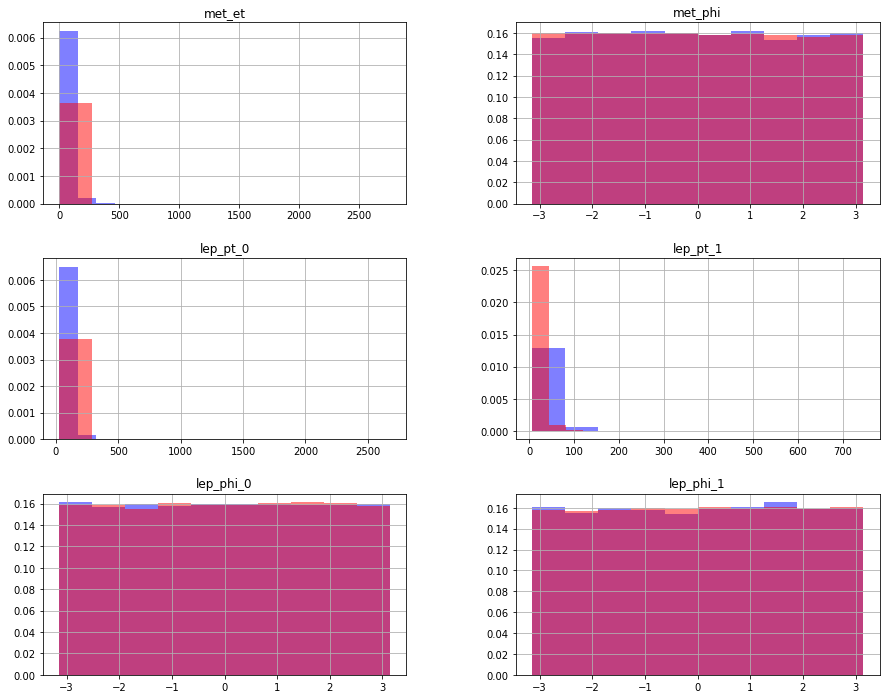

In [22]:


plt.figure()

#_, ax = plt.subplots()

ax=data[target==0].hist(weights=weights[target==0],figsize=(15,12),color='b',alpha=0.5,density=True)
ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target==1].hist(weights=weights[target==1],figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax)




plt.show()


## Transformation of the features

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)
print (X_train.shape)
print (y_train.shape)
print (weights_train.shape)
print (X_test.shape)
print (y_test.shape)
print (weights_test.shape)





#scale to mean 0 and variance 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

print ("class_weights_train:",class_weights_train)
for i in range(len(class_weights_train)):
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
    weights_test[y_test == i] *= 1/(1-train_size) # increase test weight to compensate for sampling
    
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())

print('Number of signal events: {}'.format(len(y_train[y_train == 1])))
print('Number of background events: {}'.format(len(y_train[y_train == 0])))

(447428, 6)
(447428,)
(447428,)
(149143, 6)
(149143,)
(149143,)
class_weights_train: (92.9820056955, 4.634207743199998)
Test : total weight sig 6.1294974176000006
Test : total weight bkg 124.10832722679999
Train : total weight sig 92.98200569550004
Train : total weight bkg 92.9820056955
Number of signal events: 298288
Number of background events: 149140


# Testing BDT

## Load significance function

In [26]:
from math import sqrt
from math import log
def amsasimov(s,b): # asimov (or Poisson) significance
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)


## XGBoost

Training time: 10.349012613296509
auc test: 0.7769868599731803
auc train: 0.7781898765427822
Z: 0.7603934703658803


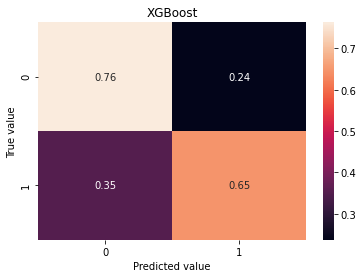

In [27]:
from sklearn.metrics import confusion_matrix 

np.random.seed(31415) # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
xgb = XGBClassifier(tree_method="hist")
#xgb = XGBClassifier(tree_method="hist",max_depth=12) # HPO, check on the web for other parameters
# not a bad idea to check for bugs without hist


starting_time = time.time( )
xgb.fit(X_train, y_train.values, sample_weight=weights_train.values,eval_metric='auc',verbose=False,eval_set=[(X_test, y_test)] ,early_stopping_rounds=50)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))

int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")

GXBoost_confusion = confusion_matrix(y_test, (y_pred_xgb > 0.5),normalize='true')

sns.heatmap(GXBoost_confusion,annot=True)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("XGBoost")
plt.show()

Training time: 12.277365446090698
auc test: 0.7769868599731803
auc train: 0.7781898765427822
Z: 0.7603934703658803


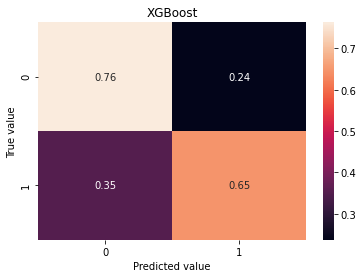

In [28]:
np.random.seed(31415) # set the random seed

starting_time = time.time( )
xgb.fit(X_train, y_train.values, sample_weight=weights_train.values,eval_metric=['auc','aucpr'],verbose=False,eval_set=[(X_test, y_test)] ,early_stopping_rounds=50)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))

int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")

GXBoost_confusion = confusion_matrix(y_test, (y_pred_xgb > 0.5),normalize='true')

sns.heatmap(GXBoost_confusion,annot=True)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("XGBoost")
plt.show()

Training time: 16.07629919052124
auc test: 0.7307253173148583
auc train: 0.7318479555923773
Z: 0.6838347643938083


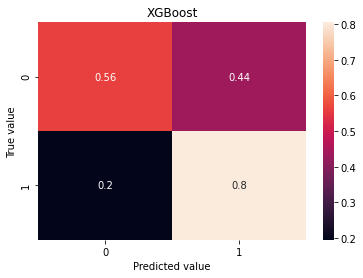

In [29]:
from sklearn.metrics import f1_score

def xgb_f1(y, t, threshold=0.5):
    t = t.get_label()
    y_bin = (y > threshold).astype(int) # works for both type(y) == <class 'numpy.ndarray'> and type(y) == <class 'pandas.core.series.Series'>
    return 'f1',f1_score(t,y_bin)

np.random.seed(31415) # set the random seed

starting_time = time.time( )
xgb.fit(X_train, y_train.values, eval_metric = xgb_f1,verbose=False,eval_set=[(X_test, y_test)] ,early_stopping_rounds=200)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))

int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")

GXBoost_confusion = confusion_matrix(y_test, (y_pred_xgb > 0.5),normalize='true')

sns.heatmap(GXBoost_confusion,annot=True)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("XGBoost")
plt.show()

##Resampling the dataset

In the cells below we shal first downsample the dataset so that the number of signal and background events are equal.

In [30]:
from sklearn.utils import resample

train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)
print (X_train.shape)
print (y_train.shape)
print (weights_train.shape)
print (X_test.shape)
print (y_test.shape)
print (weights_test.shape)

df = pd.concat([X_train, weights_train, y_train], axis=1)

label_nevents = (df[df.label==0].shape[0], df[df.label==1].shape[0] )
print ("total class number of events before subsampling",label_nevents)

df_majority = df[df.label==1]
df_minority = df[df.label==0]
            
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state = 3214) # reproducible results
       
# Combine minority class with downsampled majority class
TrainingData = pd.concat([df_majority_downsampled, df_minority])

label_nevents = (TrainingData[TrainingData.label==0].shape[0], TrainingData[TrainingData.label==1].shape[0] )
print ("total class number of events after subsampling",label_nevents)


(447428, 6)
(447428,)
(447428,)
(149143, 6)
(149143,)
(149143,)
total class number of events before subsampling (148840, 298588)
total class number of events after subsampling (148840, 148840)


In [31]:
class_weights_train = (TrainingData.mcWeight[TrainingData.label == 0].sum(), TrainingData.mcWeight[TrainingData.label == 1].sum())

print ("class_weights_train:",class_weights_train)
for i in range(len(class_weights_train)):
    TrainingData.mcWeight[TrainingData.label == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
    TrainingData.mcWeight[TrainingData.label == i] *= 1/(1-train_size) # increase test weight to compensate for sampling
    
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())

print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))

y_train = TrainingData.label
del TrainingData['label']

weights_train = TrainingData.mcWeight
del TrainingData['mcWeight']

X_train = TrainingData

#scale to mean 0 and variance 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above

class_weights_train: (92.9604778634, 2.3049106672)
Test : total weight sig 1.5357712696
Test : total weight bkg 31.0486096388
Train : total weight sig 4.630810828000002
Train : total weight bkg 92.9604778634
298588
148840


Training time: 7.766987562179565
auc test: 0.4831676531726031
auc train: 0.5291477052341927
Z: 0.27340868082990655


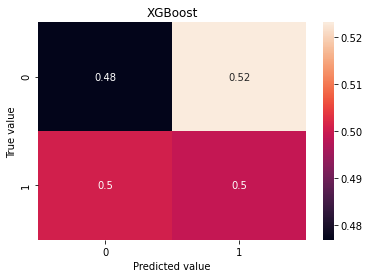

In [32]:
np.random.seed(31415) # set the random seed

starting_time = time.time( )
xgb.fit(X_train, y_train.values, eval_metric='auc',verbose=False,eval_set=[(X_test, y_test)] ,early_stopping_rounds=50)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))

int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")

GXBoost_confusion = confusion_matrix(y_test, (y_pred_xgb > 0.5),normalize='true')

sns.heatmap(GXBoost_confusion,annot=True)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("XGBoost")
plt.show()

Training time: 8.191959619522095
auc test: 0.4831676531726031
auc train: 0.5291477052341927
Z: 0.27340868082990655


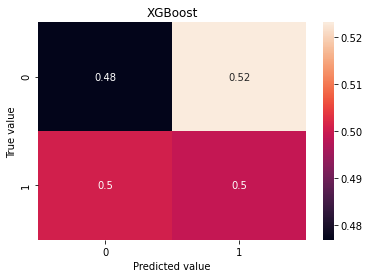

In [33]:
np.random.seed(31415) # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
xgb = XGBClassifier(tree_method="hist")
#xgb = XGBClassifier(tree_method="hist",max_depth=12) # HPO, check on the web for other parameters
# not a bad idea to check for bugs without hist


starting_time = time.time( )
xgb.fit(X_train, y_train.values, eval_metric='aucpr',verbose=False,eval_set=[(X_test, y_test)] ,early_stopping_rounds=50)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))

int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")

GXBoost_confusion = confusion_matrix(y_test, (y_pred_xgb > 0.5),normalize='true')

sns.heatmap(GXBoost_confusion,annot=True)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("XGBoost")
plt.show()

Training time: 13.996077537536621


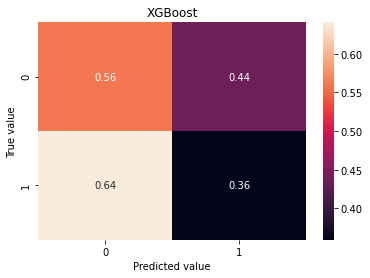

In [34]:
from sklearn.metrics import f1_score

def xgb_f1(y, t, threshold=0.5):
    t = t.get_label()
    y_bin = (y > threshold).astype(int) # works for both type(y) == <class 'numpy.ndarray'> and type(y) == <class 'pandas.core.series.Series'>
    return 'f1',f1_score(t,y_bin)

np.random.seed(31415) # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
xgb = XGBClassifier(tree_method="hist")
#xgb = XGBClassifier(tree_method="hist",max_depth=12) # HPO, check on the web for other parameters
# not a bad idea to check for bugs without hist


starting_time = time.time( )
xgb.fit(X_train, y_train.values, eval_metric = xgb_f1,verbose=False,eval_set=[(X_test, y_test)] ,early_stopping_rounds=200)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
y_pred_xgb = y_pred_xgb > 0.5

GXBoost_confusion = confusion_matrix(y_test, (y_pred_xgb > 0.5),normalize='true')

sns.heatmap(GXBoost_confusion,annot=True)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("XGBoost")
plt.show()